# Lifetime time correlation functions and hydroxide ions

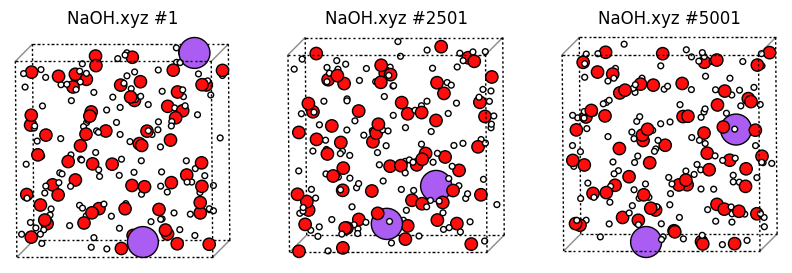

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from common import plot_trajectory
plot_trajectory("trajectories/NaOH.xyz");


The above trajectory contains two NaOH formula units (Na shown in purple).

The most robust way of assigning oxygens as either hydroxide or water is to use the ``FINDSHORTEST`` group definition, in order to assign each hydrogen to its nearest oxygen. This is good since we then do not need to worry about interatomic distances, which would be very complicated to handle during proton transfer events (which frequently occur in the trajectory).

So let's do it and plot hydroxide oxygens as F (green). Below we also define groups for hydronium (H3O+) and oxide (O not coordinating any H) - such species do not appear in this trajectory but it's good to have the definition.

In [2]:
%%sh
cat > hydroxide1.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

MaxTimestep 1000

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup SuperO FINDSHORTEST FromGroup H ToGroup O
DefineGroup HydroniumO SUBGROUPCN SuperO Coord 3
DefineGroup WaterO SUBGROUPCN SuperO Coord 2
DefineGroup HydroxideO SUBGROUPCN SuperO Coord 1
DefineGroup OxideO DIFF O SuperO
DefineGroup HydroniumH INVERTCOORDINATION HydroniumO
DefineGroup WaterH INVERTCOORDINATION WaterO
DefineGroup HydroxideH INVERTCOORDINATION HydroxideO

PrintGroup All XYZ hydroxide_colored.xyz SPECIAL HydroxideO F
EOF
OMP_NUM_THREADS=1 lionanalysis.exe hydroxide1.config > hydroxide1.out


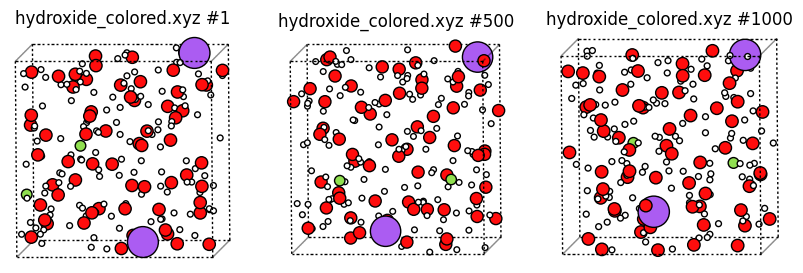

In [3]:
plot_trajectory("hydroxide_colored.xyz");

There appear two be two hydroxide ions (green) in each frame, which is what we'd expect.

## Lifetime from SSP: Stable States Picture

The SSP time correlation function gives the probability that a *clear* hydroxide O at time t_0 has NOT become a *clear* water O at time t_0+deltaT.

By fitting an exponential or double-exponential function to the decaying time correlation function, one can extract the typical hydroxide ion life time.

For this we need to know the time between frames in the trajectory. In this case, every frame is separated by 5 fs. We can specify this as ``BasicTimeUnit 0.005`` near the top of the input file:

In [4]:
%%sh
cat > hydroxide2.config <<EOF
DumpFile trajectories/NaOH.xyz
DumpFileFormat mattixyz
Overwrite
CoutFrequency 200

BasicTimeUnit 0.005

DefineGroup H ATOMICNUMBER H
DefineGroup O ATOMICNUMBER O
DefineGroup Na ATOMICNUMBER Na

DefineGroup DefiniteHydroxideO BOND O H MaxDist 1.4 Coord 1
DefineGroup DefiniteWaterO BOND O H MaxDist 1.1 Coord 2

# see documentation for details - for SSP the "ValueEscape" lines should be set exactly as below
# MaxHistory 10 RealTime means a maximum correlation time of 10 ps
TResidenceTimeSSP \
    Reactants DefiniteHydroxideO \
    Products DefiniteWaterO \
    Filename ssp_hydroxide_lifetime.txt \
    OldValueEscape1 0 0 0 UR \
    NewValueEscape2! 0 0 0 VR \
    MaxHistory 10 RealTime PrintEvery 2000

EOF
OMP_NUM_THREADS=1 lionanalysis.exe hydroxide2.config > hydroxide2.out


In [5]:
!head ssp_hydroxide_lifetime.txt

### DESCR TResidenceTimeSSP     Reactants DefiniteHydroxideO     Products DefiniteWaterO     Filename ssp_hydroxide_lifetime.txt     OldValueEscape1 0 0 0 UR     NewValueEscape2! 0 0 0 VR     MaxHistory 10 RealTime PrintEvery 2000
### count 5001 timeunit 0.005
#t(ps) value sum count
0 1 7566 7566
0.005 1 7565 7565
0.01 0.999603 7560 7563
0.015 0.997487 7542 7561
0.02 0.995106 7523 7560
0.025 0.993384 7508 7558
0.03 0.991662 7493 7556


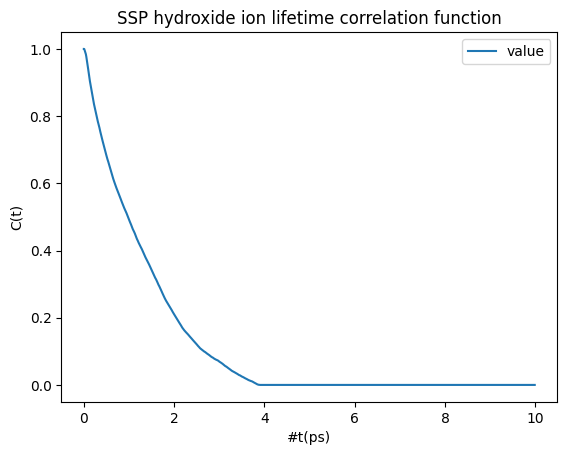

In [6]:
df = pd.read_csv("ssp_hydroxide_lifetime.txt", sep="\s+", skiprows=2)
df.plot(x="#t(ps)", y="value", ylabel="C(t)", title="SSP hydroxide ion lifetime correlation function");

After about 5 ps the curve has decayed to 0, meaning that ALL *clear* hydroxide ions have turned into *clear* water molecules after at most 5 ps.

To get the lifetime, we can fit this to a double-exponential curve and use the integral under the curve as the estimated lifetime.

This is the exact method that was used in [Hellstrom, Ceriotti, Behler](https://doi.org/10.1021/acs.jpcb.8b06433) - in that paper the life time at this NaOH concentration would be somewhere between 1.33 and 1.74 ps (see Fig. 11). In this tutorial we get a value of 1.27 ps, which is explained by the very short MD simulation in this tutorial (but very thorough ones in the paper).

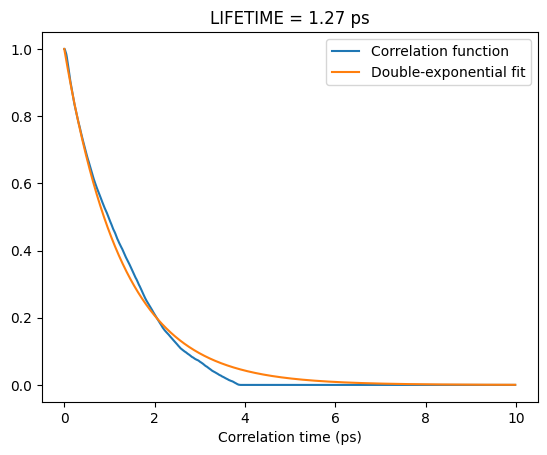

In [7]:
from scipy.optimize import curve_fit
def double_exp(x, A: float, tau1: float, tau2: float):
    return A*np.exp(-x/tau1) + (1-A)*np.exp(-x/tau2)

p0 = 0.1, 0.3, 3.0  # A, tau1, tau2
x = df["#t(ps)"].to_numpy()
y = df["value"].to_numpy()

popt, _ = curve_fit(double_exp, x, y, p0=p0)
A, tau1, tau2 = popt
prediction = double_exp(x, A, tau1, tau2)

lifetime = A*tau1 + (1-A)*tau2

plt.plot(x, y, '-')
plt.plot(x, prediction)
plt.title(f"LIFETIME = {lifetime:.2f} ps")
plt.xlabel("Correlation time (ps)")
plt.legend(["Correlation function", "Double-exponential fit"]);
